<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Logo_UNIR.png" width="350" height="175">

# *TFM: Comparación y optimización de algoritmos de Machine Learning sobre el éxito de campañas de marketing bancarias*

Autor: ***Jorge López Pérez***

***

## ***7. Selección de características***

A lo largo de este cuaderno, realizaremos el proceso de selección de características, explorando diferentes técnicas.

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

#metricas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#imputers
from sklearn.impute import KNNImputer

#escalers
from sklearn.preprocessing import StandardScaler

#selectores características
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel

warnings.filterwarnings("ignore")

In [ ]:
# leemos los datos limpios
data = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/clean_data.csv')
data.shape

(41176, 21)

Separamos los datos en train y test que utilizaremos hasta el final del estudio (utilizaremos stratify para tener el mismo porcentaje de instancias de cada clase en train y test):

In [ ]:
x,y = data.drop(['y'], axis=1), data['y'].copy()
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, stratify=y, random_state=44)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34999, 20)
(34999,)
(6177, 20)
(6177,)


***

#### 7.1 Pipeline

In [ ]:
numericas = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categoricas_nominal = ['job','marital', 'poutcome']
categoricas_ordinal = ['education', 'month', 'day_of_week']
categoricas_dicotomicas = ['default', 'housing', 'loan', 'contact']

categoricas_nominal_oh = ['job_housemaid','job_services','job_admin.','job_blue-collar','job_technician','job_retired','job_management','job_unemployed','job_self-employed','job_entrepreneur','job_student',
                          'marital_married', 'marital_single', 'marital_divorced',
                          'poutcome_nonexistent', 'poutcome_failure', 'poutcome_success']
categoricas_dicotomicas_oh = ['default_no', 'default_yes',
                              'housing_no', 'housing_yes',
                              'loan_no', 'loan_yes',
                              'contact_cellular', 'contact_telephone']

total_columns_after_transform = categoricas_ordinal + categoricas_nominal_oh + categoricas_dicotomicas_oh + numericas

def round_imputed_values(X):
    X_rounded = np.round(X)
    return X_rounded

cat_ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder(categories=[
         ["basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree"],
         ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
         ["mon","tue","wed","thu","fri"]]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer', KNNImputer(n_neighbors=10)),
    ('rounding', FunctionTransformer(round_imputed_values))
])

cat_nominal_transformer = Pipeline([
     ('encoder_prev', OrdinalEncoder(categories=[
         ['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student'],
         ['married', 'single', 'divorced'],
         ['nonexistent', 'failure', 'success']
         ]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('imputer', KNNImputer(n_neighbors=10)),
     ('rounding', FunctionTransformer(round_imputed_values)),
     ('encoder', OneHotEncoder())
])

cat_dicotomico_transformer = Pipeline([
     ('encoder_prev', OrdinalEncoder(categories=[
         ['no', 'yes'],
         ['no', 'yes'],
         ['no', 'yes'],
         ['cellular', 'telephone']
         ]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('imputer', KNNImputer(n_neighbors=10)),
     ('rounding', FunctionTransformer(round_imputed_values)),
     ('encoder', OneHotEncoder())
])

numericas_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
        ('cat_ordinal', cat_ordinal_transformer, categoricas_ordinal),
        ('cat_nominal', cat_nominal_transformer, categoricas_nominal),
        ('cat_dicotomico', cat_dicotomico_transformer, categoricas_dicotomicas),
        ('numericas', numericas_transformer, numericas)
    ], remainder='passthrough')

pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

In [ ]:
label_encoder = LabelEncoder()
y_train_prepared = label_encoder.fit_transform(y_train)
y_test_prepared = label_encoder.transform(y_test)
print(y_train_prepared.shape)
print(y_test_prepared.shape)

(34999,)
(6177,)


In [ ]:
x_train_prepared = pipeline.fit_transform(x_train)
x_test_prepared = pipeline.transform(x_test)
print(x_train_prepared.shape)
print(x_test_prepared.shape)

(34999, 38)
(6177, 38)


***

#### 7.2 Selección de características

In [ ]:
x_train_prepared = pd.DataFrame(x_train_prepared, columns=total_columns_after_transform)

##### 7.2.1 RFECV

In [ ]:
def plot_fs(fs):
  n_scores = len(fs.cv_results_["mean_test_score"])
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Mean test accuracy")
  plt.errorbar(
      range(0, n_scores),
      fs.cv_results_["mean_test_score"],
      yerr=fs.cv_results_["std_test_score"],
  )
  plt.title("Recursive Feature Elimination \nwith correlated features")
  plt.show()

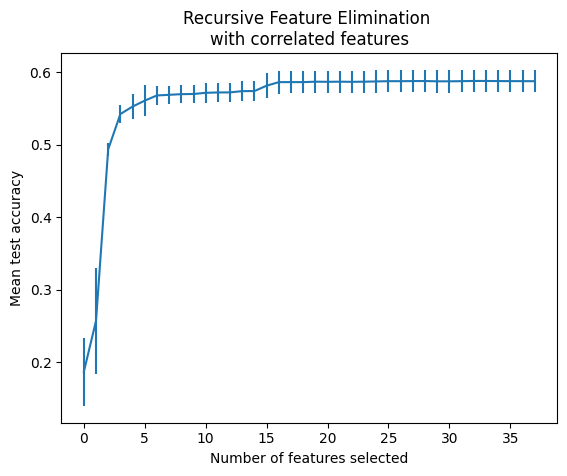

Columnas a eliminar (estimator: lr): ['day_of_week', 'job_housemaid', 'default_yes', 'age', 'previous']
Ranking features: (estimator: lr): [1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 5 1 1 1 6 1 1 1 1
 1]


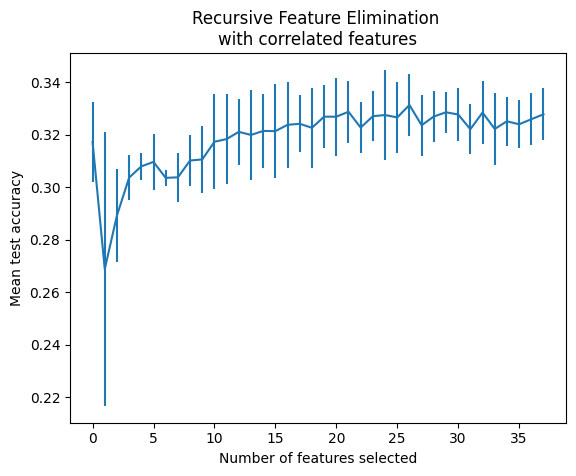

Columnas a eliminar (estimator: dt): ['job_housemaid', 'job_retired', 'job_unemployed', 'job_self-employed', 'job_entrepreneur', 'job_student', 'poutcome_nonexistent', 'poutcome_success', 'default_no', 'default_yes', 'emp.var.rate']
Ranking features: (estimator: dt): [ 1  1  1  2  1  1  1  1  8  1  4  5  3  6  1  1  1  9  1 10 11 12  1  1
  1  1  1  1  1  1  1  1  1  7  1  1  1  1]


In [ ]:
estimators = dict([
      ('lr', LogisticRegression(random_state=44)),
      ('dt', DecisionTreeClassifier(random_state=44)),
])

for key, model in estimators.items():
  fs = RFECV(model, cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=44), scoring='average_precision')
  fs.fit(x_train_prepared,y_train_prepared)
  plot_fs(fs)
  columns_drop = list(x_train_prepared.columns[fs.support_ == False])
  print(f'Columnas a eliminar (estimator: {key}): {columns_drop}')
  print(f'Ranking features: (estimator: {key}): {fs.ranking_}')

In [ ]:
columns_drop_lr = ['day_of_week', 'job_housemaid', 'default_yes', 'age', 'previous']
print('Columnas a eliminar: ', columns_drop_lr)
x_train_prepared_fs = x_train_prepared.drop(columns_drop_lr,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['day_of_week', 'job_housemaid', 'default_yes', 'age', 'previous']
(34999, 33)


In [ ]:
columns_drop_dt = ['job_housemaid', 'job_retired', 'job_unemployed', 'job_self-employed', 'job_entrepreneur', 'job_student', 'poutcome_nonexistent', 'poutcome_success', 'default_no', 'default_yes', 'emp.var.rate']
print('Columnas a eliminar: ', columns_drop_dt)
x_train_prepared_fs = x_train_prepared.drop(columns_drop_dt,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['job_housemaid', 'job_retired', 'job_unemployed', 'job_self-employed', 'job_entrepreneur', 'job_student', 'poutcome_nonexistent', 'poutcome_success', 'default_no', 'default_yes', 'emp.var.rate']
(34999, 27)


##### 7.2.2 VarianceThreshold

In [ ]:
fs = VarianceThreshold(threshold=0.03)
fs.fit(x_train_prepared)

VarianceThreshold(threshold=0.03)

In [ ]:
columns_drop = list(x_train_prepared.columns[fs.get_support() == False])
print('Columnas a eliminar: ', columns_drop)
print('Varianzas features: ', fs.variances_)
x_train_prepared_fs = x_train_prepared.drop(columns_drop,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['job_housemaid', 'job_unemployed', 'job_student', 'default_no', 'default_yes']
Varianzas features:  [4.12537420e+00 4.17725109e+00 1.98932755e+00 2.49995493e-02
 8.66476696e-02 1.89529735e-01 1.74409961e-01 1.41517674e-01
 3.95560726e-02 6.59852546e-02 2.45385108e-02 3.33239679e-02
 3.44397231e-02 2.05869462e-02 2.38959364e-01 2.03236355e-01
 9.88148122e-02 1.18130105e-01 9.24160221e-02 3.26851003e-02
 5.71412243e-05 5.71412243e-05 2.48526453e-01 2.48526453e-01
 1.29594034e-01 1.29594034e-01 2.31343277e-01 2.31343277e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
(34999, 33)


##### 7.2.3 SelectKBest

In [ ]:
fs = SelectKBest(k=33)
fs.fit(x_train_prepared,y_train_prepared)

SelectKBest(k=33)

In [ ]:
columns_drop = list(x_train_prepared.columns[fs.get_support() == False])
print('Columnas a eliminar: ', columns_drop)
print('Scores features: ', fs.scores_)
x_train_prepared_fs = x_train_prepared.drop(columns_drop,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['job_management', 'default_no', 'default_yes', 'loan_no', 'loan_yes']
Scores features:  [9.40797479e+01 3.76598143e+01 4.16840702e+00 7.62911419e-01
 3.63074124e+01 2.79587020e+01 1.84232685e+02 1.24289825e+00
 3.13322861e+02 1.86245866e-02 1.24936035e+01 1.95397259e+00
 1.12573125e+01 3.15516085e+02 5.94751204e+01 9.76652353e+01
 4.71225563e+00 1.38997764e+03 3.59389388e+01 3.92917363e+03
 2.53930128e-01 2.53930230e-01 9.34640777e+00 9.34640777e+00
 7.38254719e-01 7.38254719e-01 7.59928826e+02 7.59928826e+02
 2.97315054e+01 6.89314332e+03 1.58446196e+02 4.17214515e+03
 2.00598872e+03 3.42234472e+03 6.54797497e+02 8.28548401e+01
 3.69010214e+03 5.04785742e+03]
(34999, 33)


##### 7.2.4 SelectFromModel

In [ ]:
for key, model in estimators.items():
  fs = SelectFromModel(model, threshold='0.4*median')
  fs.fit(x_train_prepared,y_train_prepared)
  columns_drop = list(x_train_prepared.columns[fs.get_support() == False])
  print(f'Columnas a eliminar del modelo {key}: {columns_drop}')
  if (key=='lr'):
    print(f'Coeficientes features: {fs.estimator_.coef_}')
  else:
    print(f'Importancias features: {fs.estimator_.feature_importances_}')

Columnas a eliminar del modelo lr: ['education', 'month', 'day_of_week', 'job_housemaid', 'job_admin.', 'job_unemployed', 'default_yes', 'age', 'previous']
Coeficientes features: [[ 5.90860851e-02 -6.41462930e-02  1.69226535e-02  3.94208154e-02
  -2.93238612e-01 -4.49838079e-02 -3.57686381e-01 -1.02106412e-01
   4.12635682e-01 -1.63131840e-01  8.60947762e-02 -2.54468601e-01
  -2.90935676e-01  2.42429585e-01 -2.77983498e-01 -1.99941406e-01
  -2.48045566e-01 -1.86778240e-01 -7.61610167e-01  2.22417936e-01
  -7.20664321e-01 -5.30614996e-03 -3.43847513e-01 -3.82122957e-01
  -3.30577424e-01 -3.95393046e-01  1.41334923e-01 -8.67305394e-01
   1.42037590e-03  1.17988478e+00 -1.06490276e-01 -1.81635932e-01
  -6.10893520e-04 -1.44075942e+00  6.22325537e-01  2.05647480e-01
   5.01256865e-01 -3.94079424e-01]]
Columnas a eliminar del modelo dt: ['poutcome_success', 'default_no', 'default_yes', 'emp.var.rate']
Importancias features: [0.03942328 0.00712169 0.03645368 0.00411383 0.00687616 0.00813048


In [ ]:
columns_drop_lr = ['education', 'month', 'day_of_week', 'job_housemaid', 'job_admin.', 'job_unemployed', 'default_yes', 'age', 'previous']
print('Columnas a eliminar: ', columns_drop_lr)
x_train_prepared_fs = x_train_prepared.drop(columns_drop_lr,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['education', 'month', 'day_of_week', 'job_housemaid', 'job_admin.', 'job_unemployed', 'default_yes', 'age', 'previous']
(34999, 29)


In [ ]:
columns_drop_dt = ['poutcome_success', 'default_no', 'default_yes', 'emp.var.rate']
print('Columnas a eliminar: ', columns_drop_dt)
x_train_prepared_fs = x_train_prepared.drop(columns_drop_dt,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['poutcome_success', 'default_no', 'default_yes', 'emp.var.rate']
(34999, 34)


***

##### 7.2.5 Combinación estrategias anteriores

In [ ]:
columns_drop = ['job_housemaid', 'job_unemployed', 'default_no', 'default_yes'] #presentes en al menos 3 listas de las 6
print('Columnas a eliminar: ', columns_drop)
x_train_prepared_fs = x_train_prepared.drop(columns_drop,axis=1)
print(x_train_prepared_fs.shape)

Columnas a eliminar:  ['job_housemaid', 'job_unemployed', 'default_no', 'default_yes']
(34999, 34)


***

#### 7.3 Modelos y cálculo de métricas

Definimos la arquitectura inicial de nuestra RN. Empezaremos con una arquitectura sencilla que optimizaremos cuando llegue el momento:

In [ ]:
def build_rn():
  inputs = keras.Input(shape=(x_train_prepared_fs.shape[1],))

  hidden1 = keras.layers.Dense(32, activation='relu')(inputs)
  hidden2 = keras.layers.Dense(16, activation='relu')(hidden1)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden2)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
def initialize_models():

  estimators = [
      ('lr', LogisticRegression(random_state=44)),
      ('dt', DecisionTreeClassifier(random_state=44)),
      ('kn', KNeighborsClassifier()),
      ('rn', KerasClassifier(model=build_rn, epochs=10, batch_size=32, verbose=0, random_state=44)),
      ('rf', RandomForestClassifier(random_state=44)),
      ('xgb', xgboost.XGBClassifier(random_state=44)),
      ('hist', HistGradientBoostingClassifier(random_state=44))
  ]

  dict_estimators = dict(estimators)

  voting = VotingClassifier(estimators=estimators, voting='soft')
  dict_estimators['voting'] = voting

  return dict_estimators

Funciones para cálculo de métricas:

In [ ]:
def probas_to_abs(probas, umbral=0.5):
  abs = []
  for proba in probas:
    if (proba >= umbral): abs.append(1)
    else: abs.append(0)
  return abs

def calculate_cv_metrics(estimator,x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []
  scores_accuracy = []
  scores_roc = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))
    scores_precision.append(precision_score(Y_test, probas_to_abs(preds_test)))
    scores_recall.append(recall_score(Y_test, probas_to_abs(preds_test)))
    scores_f1.append(f1_score(Y_test, probas_to_abs(preds_test)))
    scores_accuracy.append(accuracy_score(Y_test, probas_to_abs(preds_test)))
    scores_roc.append(roc_auc_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)
  mean_precision = round(np.mean(scores_precision), 4)
  mean_recall = round(np.mean(scores_recall), 4)
  mean_f1 = round(np.mean(scores_f1), 4)
  mean_accuracy = round(np.mean(scores_accuracy), 4)
  mean_roc = round(np.mean(scores_roc), 4)

  return mean_auc_pr, mean_precision, mean_recall, mean_f1, mean_accuracy, mean_roc


def calculate_pr_cv():
  modelos = initialize_models()
  scores = []
  for key, model in modelos.items():
      score,_,_,_,_,_ = calculate_cv_metrics(model, x_train_prepared_fs.to_numpy(), y_train_prepared)
      scores.append(score)
      print(f'CV -> AUC PR score for {key}: ', score)
  print('')
  print('Mean AUC PR score: ', round(np.mean(scores), 4))


def calculate_baseline_metrics_cv():
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1,_,_ = calculate_cv_metrics(model, x_train_prepared_fs.to_numpy(), y_train_prepared)
      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print('')
      print('**********************************')
      print('')

***

#### 7.4 Opciones de selección de características

***OPCIÓN 1: RFECV (LogisticRegression)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5881
CV -> AUC PR score for dt:  0.3225
CV -> AUC PR score for kn:  0.4788
CV -> AUC PR score for rn:  0.6362
CV -> AUC PR score for rf:  0.6244
CV -> AUC PR score for xgb:  0.6453
CV -> AUC PR score for hist:  0.6664
CV -> AUC PR score for voting:  0.6551

Mean AUC PR score:  0.5771


***OPCIÓN 2: RFECV (DecisionTree)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5852
CV -> AUC PR score for dt:  0.3231
CV -> AUC PR score for kn:  0.4784
CV -> AUC PR score for rn:  0.6287
CV -> AUC PR score for rf:  0.6477
CV -> AUC PR score for xgb:  0.6478
CV -> AUC PR score for hist:  0.6663
CV -> AUC PR score for voting:  0.6584

Mean AUC PR score:  0.5794


***OPCIÓN 3: VarianceThreshold (threshold=0.03)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.588
CV -> AUC PR score for dt:  0.3325
CV -> AUC PR score for kn:  0.478
CV -> AUC PR score for rn:  0.6341
CV -> AUC PR score for rf:  0.6456
CV -> AUC PR score for xgb:  0.6483
CV -> AUC PR score for hist:  0.6685
CV -> AUC PR score for voting:  0.6635

Mean AUC PR score:  0.5823


***OPCIÓN 4: SelectKBest(score_func=f_classif, k=33)***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5879
CV -> AUC PR score for dt:  0.3325
CV -> AUC PR score for kn:  0.4785
CV -> AUC PR score for rn:  0.6343
CV -> AUC PR score for rf:  0.6434
CV -> AUC PR score for xgb:  0.6448
CV -> AUC PR score for hist:  0.6655
CV -> AUC PR score for voting:  0.6605

Mean AUC PR score:  0.5809


***OPCIÓN 5: SelectFromModel(LogisticRegression) (threshold='0.4 * median')***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5879
CV -> AUC PR score for dt:  0.3216
CV -> AUC PR score for kn:  0.4836
CV -> AUC PR score for rn:  0.6333
CV -> AUC PR score for rf:  0.622
CV -> AUC PR score for xgb:  0.6499
CV -> AUC PR score for hist:  0.6663
CV -> AUC PR score for voting:  0.6508

Mean AUC PR score:  0.5769


***OPCIÓN 6: SelectFromModel(DecisionTree) (threshold='0.4 * median')***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5859
CV -> AUC PR score for dt:  0.3304
CV -> AUC PR score for kn:  0.4755
CV -> AUC PR score for rn:  0.6253
CV -> AUC PR score for rf:  0.6405
CV -> AUC PR score for xgb:  0.6452
CV -> AUC PR score for hist:  0.6652
CV -> AUC PR score for voting:  0.6587

Mean AUC PR score:  0.5783


***OPCIÓN 7: Combinación estrategias anteriores***

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5878
CV -> AUC PR score for dt:  0.3292
CV -> AUC PR score for kn:  0.4782
CV -> AUC PR score for rn:  0.6363
CV -> AUC PR score for rf:  0.6418
CV -> AUC PR score for xgb:  0.6456
CV -> AUC PR score for hist:  0.6686
CV -> AUC PR score for voting:  0.6615

Mean AUC PR score:  0.5811


***

#### 7.5 Métricas CV mejor opción (OPCIÓN 3)


In [ ]:
calculate_baseline_metrics_cv()

CV -> AUC PR score for lr:  0.588
CV -> Precision score for lr:  0.6639
CV -> Recall score for lr:  0.4045
CV -> F1 score for lr:  0.5022

**********************************

CV -> AUC PR score for dt:  0.3325
CV -> Precision score for dt:  0.5202
CV -> Recall score for dt:  0.5389
CV -> F1 score for dt:  0.5293

**********************************

CV -> AUC PR score for kn:  0.478
CV -> Precision score for kn:  0.5997
CV -> Recall score for kn:  0.4162
CV -> F1 score for kn:  0.4913

**********************************

CV -> AUC PR score for rn:  0.6341
CV -> Precision score for rn:  0.6358
CV -> Recall score for rn:  0.5153
CV -> F1 score for rn:  0.5646

**********************************

CV -> AUC PR score for rf:  0.6456
CV -> Precision score for rf:  0.6578
CV -> Recall score for rf:  0.4979
CV -> F1 score for rf:  0.5663

**********************************

CV -> AUC PR score for xgb:  0.6483
CV -> Precision score for xgb:  0.6411
CV -> Recall score for xgb:  0.5382
CV -> F1 sc

***